# **Final Project: AI-Powered Image Wizard**

* Name: **Aktham Almomani**
* Date: **12/09/2024**

## **Stage 2: Super Resolution**

## **Introduction**

Super-resolution is a fundamental task in computer vision that aims to enhance the resolution of an image, transforming low-resolution (LR) images into high-resolution (HR) ones. This process improves image quality, making finer details visible and enabling better visual experiences. The AI-Powered Image Wizard provides a sophisticated and user-friendly interface for performing super-resolution tasks using state-of-the-art machine learning models.

## **Dataset**

The DIV2K Dataset (DIVerse 2K resolution dataset) is a benchmark dataset widely used for training and evaluating super-resolution models. Released as part of the NTIRE (New Trends in Image Restoration and Enhancement) challenges, it contains high-quality, high-resolution images paired with their low-resolution counterparts, making it an excellent resource for developing deep learning models for image super-resolution tasks.

## **Import Necessary Librararies**

In [1]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from diffusers import VQModel
from kagglehub import dataset_download
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import torch.nn as nn
from diffusers import StableDiffusionUpscalePipeline
from tqdm import tqdm


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## **Dataset Download**

In [2]:
# Download DIV2K dataset:
path = dataset_download("soumikrakshit/div2k-high-resolution-images")
print("Path to dataset files:", path)

100%|██████████| 3.71G/3.71G [02:58<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1


In [3]:
print("Contents of downloaded dataset:")
print(os.listdir(path))

Contents of downloaded dataset:
['DIV2K_valid_HR', 'DIV2K_train_HR']


In [4]:
# Define the directories:
directories = [
    "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_HR",
    "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_HR"
]

# Iterate through each directory and count the files:
for dir_path in directories:
    if os.path.exists(dir_path):
        count = sum(len(files) for _, _, files in os.walk(dir_path))
        print(f"Directory: {dir_path} contains {count} image files.")
    else:
        print(f"Directory: {dir_path} does not exist.")

Directory: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_HR contains 800 image files.
Directory: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_HR contains 100 image files.


## **Automated Generation of Low-Resolution Images for Super-Resolution Training**

The ability to generate high-quality low-resolution (LR) datasets from high-resolution (HR) images is a critical step in the preparation of data for training super-resolution models. This process ensures that models learn to reconstruct fine details and upscale images effectively. The provided function, create_low_res_images_recursive, automates this process by recursively processing images in a source directory (containing HR images) and creating their LR counterparts using bicubic downsampling.

This implementation is tailored for the DIV2K Dataset, a widely used benchmark for super-resolution tasks. The script ensures the consistency of the dataset structure, maintaining a mirrored directory tree for easy access and seamless integration into training pipelines. The LR images are scaled down by a specified factor (default is 4x) while preserving image quality as much as possible.


Title:
Automated Generation of Low-Resolution Images for Super-Resolution Training

Introduction:
The ability to generate high-quality low-resolution (LR) datasets from high-resolution (HR) images is a critical step in the preparation of data for training super-resolution models. This process ensures that models learn to reconstruct fine details and upscale images effectively. The provided function, create_low_res_images_recursive, automates this process by recursively processing images in a source directory (containing HR images) and creating their LR counterparts using bicubic downsampling.

This implementation is tailored for the DIV2K Dataset, a widely used benchmark for super-resolution tasks. The script ensures the consistency of the dataset structure, maintaining a mirrored directory tree for easy access and seamless integration into training pipelines. The LR images are scaled down by a specified factor (default is 4x) while preserving image quality as much as possible.

**Key Features:**

* Recursive Processing: The function traverses the directory tree of HR images, ensuring that subdirectories and files are mirrored in the LR output directory.

* Bicubic Downsampling: Each HR image is resized using the bicubic interpolation method, a standard for generating LR images in super-resolution tasks.

* Error Handling: The script includes error handling to ensure that invalid or corrupted images do not disrupt the processing pipeline.

* Scalability: By leveraging directory mirroring and recursive traversal, the function can efficiently process large datasets like DIV2K.

* Output Structure: The script saves LR images in separate directories (DIV2K_train_LR and DIV2K_valid_LR), mirroring the structure of the original HR dataset directories (DIV2K_train_HR and DIV2K_valid_HR).

In [5]:
# Function to recursively process images:
def create_low_res_images_recursive(input_dir, output_dir, scale=4):
    for root, dirs, files in os.walk(input_dir):
        for img_file in files:
            img_path = os.path.join(root, img_file)
            # Create a mirrored subdirectory structure in the output directory:
            relative_path = os.path.relpath(root, input_dir)
            target_dir = os.path.join(output_dir, relative_path)
            os.makedirs(target_dir, exist_ok=True)

            # Process the image:
            try:
                img = Image.open(img_path)
                lr_img = img.resize((img.width // scale, img.height // scale), Image.BICUBIC)
                lr_img.save(os.path.join(target_dir, img_file))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Paths for high-resolution images and low-resolution output:
hr_train_dir = "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_HR"
hr_val_dir = "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_HR"
lr_train_dir = "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_LR"
lr_val_dir = "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_LR"

os.makedirs(lr_train_dir, exist_ok=True)
os.makedirs(lr_val_dir, exist_ok=True)

# Process training and validation datasets:
create_low_res_images_recursive(hr_train_dir, lr_train_dir)
create_low_res_images_recursive(hr_val_dir, lr_val_dir)

print(f"Low-resolution images saved to: {lr_train_dir} and {lr_val_dir}")
print(f"High-resolution images are in: {hr_train_dir} and {hr_val_dir}")

Low-resolution images saved to: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_LR and /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_LR
High-resolution images are in: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_HR and /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_HR


In [6]:
# Define the directories
directories = [
    "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_HR",
    "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_HR",
    "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_LR",
    "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_LR"
]

# Iterate through each directory and count the files
for dir_path in directories:
    if os.path.exists(dir_path):
        count = sum(len(files) for _, _, files in os.walk(dir_path))
        print(f"Directory: {dir_path} contains {count} image files.")
    else:
        print(f"Directory: {dir_path} does not exist.")

Directory: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_HR contains 800 image files.
Directory: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_HR contains 100 image files.
Directory: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_LR contains 800 image files.
Directory: /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_LR contains 100 image files.


In [7]:
# Function to get all image file paths (ignoring directories):
def get_image_files(directory, num_images):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            # Check if it's an image file by its extension
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_files.append(os.path.join(root, file))
            if len(image_files) == num_images:  # Stop when we have enough images
                break
        if len(image_files) == num_images:
            break
    return image_files

In [8]:
def visualize_image_pairs(hr_dir, lr_dir, num_images=5):
    hr_files = get_image_files(hr_dir, num_images)
    lr_files = get_image_files(lr_dir, num_images)

    for i, (hr_img_path, lr_img_path) in enumerate(zip(hr_files, lr_files)):
        hr_image = Image.open(hr_img_path)
        lr_image = Image.open(lr_img_path)

        # Display image dimensions and quality
        print(f"Image {i+1}:")
        print(f"  HR size: {hr_image.size}")
        print(f"  LR size: {lr_image.size}")

        # Show HR and LR images side by side
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(hr_image)
        plt.title(f"HR Image {i+1}")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(lr_image)
        plt.title(f"LR Image {i+1}")
        plt.axis("off")
        plt.show()

Image 1:
  HR size: (1356, 2040)
  LR size: (339, 510)


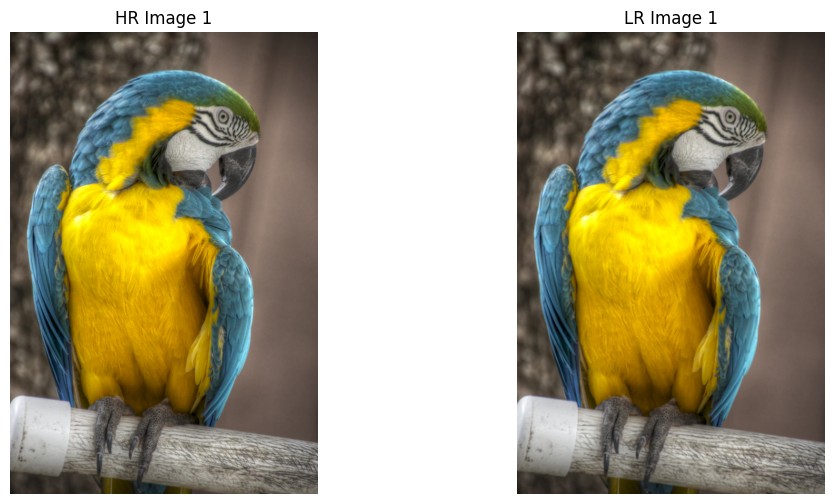

Image 2:
  HR size: (1356, 2040)
  LR size: (339, 510)


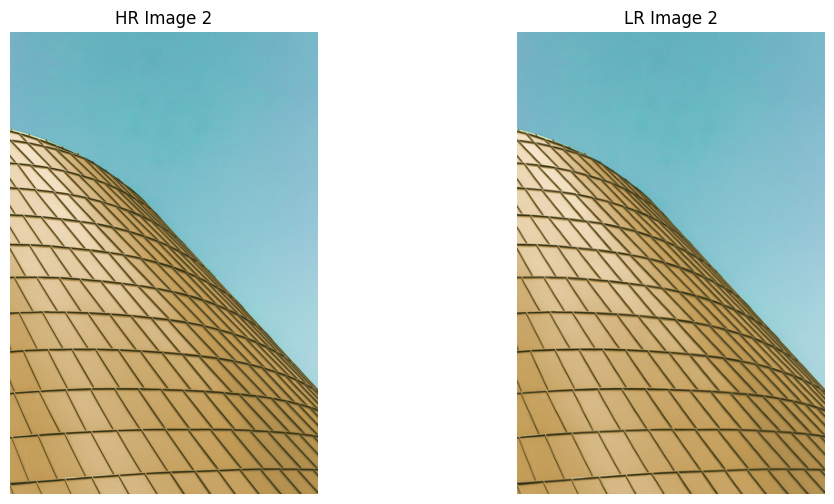

Image 3:
  HR size: (2040, 1356)
  LR size: (510, 339)


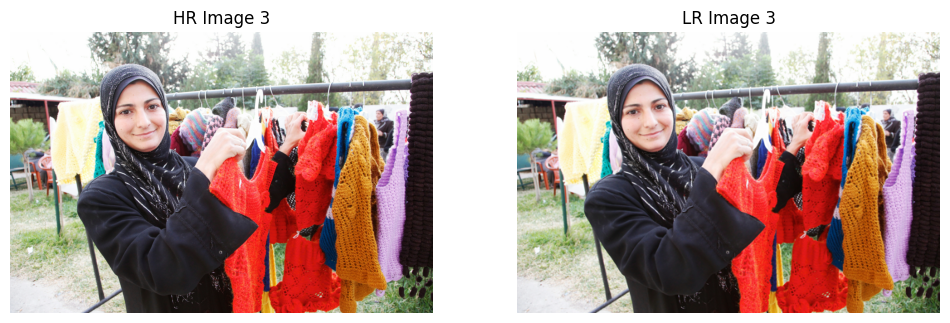

Image 4:
  HR size: (2040, 1356)
  LR size: (510, 339)


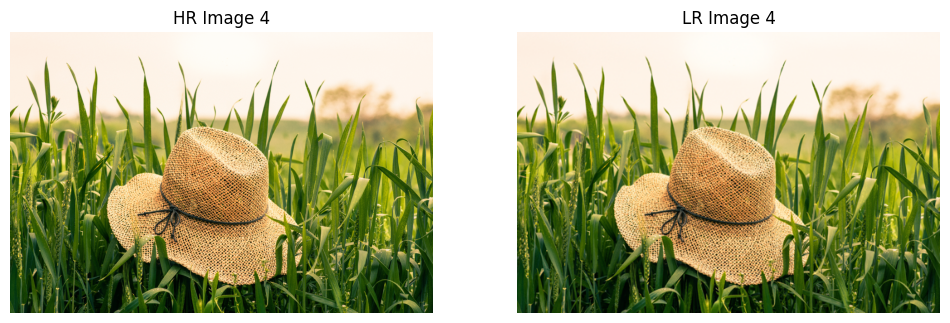

Image 5:
  HR size: (2040, 1356)
  LR size: (510, 339)


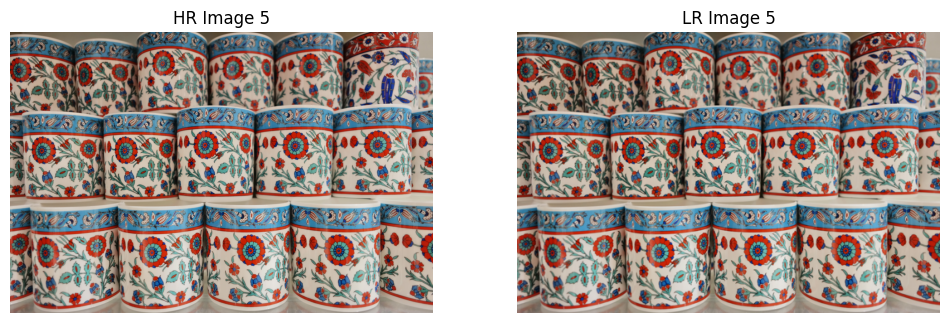

In [9]:
# Paths for high-resolution and low-resolution images:
visualize_image_pairs(hr_train_dir, lr_train_dir)

## **EDSR-PyTorch Model Download**

EDSR-PyTorch is a PyTorch implementation of the Enhanced Deep Residual Networks (EDSR), a state-of-the-art deep learning model for single-image super-resolution. Developed as part of the NTIRE 2017 Super-Resolution Challenge, EDSR delivers cutting-edge performance by leveraging advanced deep learning techniques and architectures specifically designed to improve the clarity and quality of upscaled images. The repository provides a robust framework for researchers and developers to use, fine-tune, or extend EDSR for various super-resolution tasks.

**Key Features of EDSR-PyTorch**

* Enhanced Deep Residual Networks (EDSR): EDSR builds upon traditional residual networks (ResNet) by removing unnecessary batch normalization layers and focusing on learning effective residual connections. This improvement significantly boosts performance while reducing computational overhead.

*Scalable Super-Resolution: EDSR supports multiple scaling factors (x2, x3, x4, etc.), allowing users to enhance images to different resolution levels based on their requirements.

* High-Performance Models: The repository includes both the EDSR baseline and the EDSR+ model: EDSR Baseline: A lightweight version optimized for fast training and inference and EDSR+: A larger, more powerful model for superior image quality.

* Pre-Trained Weights: Pre-trained weights for commonly used scaling factors (e.g., x4) are available, enabling users to leverage state-of-the-art performance without requiring extensive training.

* Flexibility for Fine-Tuning: The repository supports easy fine-tuning of the EDSR model on custom datasets, making it ideal for both academic research and industry applications.


In [10]:
!pwd

/content


In [11]:
!ls

sample_data


In [12]:
!git clone https://github.com/thstkdgus35/EDSR-PyTorch.git
%cd EDSR-PyTorch

Cloning into 'EDSR-PyTorch'...
remote: Enumerating objects: 806, done.
remote: Total 806 (delta 0), reused 0 (delta 0), pack-reused 806 (from 1)
Receiving objects: 100% (806/806), 63.09 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (516/516), done.
/content/EDSR-PyTorch


In [13]:
!mkdir -p experiment/model

In [14]:
!pwd

/content/EDSR-PyTorch


In [15]:
!ls -l

total 32
drwxr-xr-x 3 root root  4096 Dec  7 11:09 experiment
drwxr-xr-x 2 root root  4096 Dec  7 11:09 figs
-rw-r--r-- 1 root root  1069 Dec  7 11:09 LICENSE
-rwxr-xr-x 1 root root 10940 Dec  7 11:09 README.md
drwxr-xr-x 5 root root  4096 Dec  7 11:09 src
drwxr-xr-x 2 root root  4096 Dec  7 11:09 test


In [16]:
%cd /content/EDSR-PyTorch/experiment/model

/content/EDSR-PyTorch/experiment/model


In [17]:
!ls -l

total 0


In [19]:
!wget http://cv.snu.ac.kr/research/EDSR/models/edsr_baseline_x4-6b446fab.pt -O edsr_baseline_x4.pt

--2024-12-07 11:09:39--  http://cv.snu.ac.kr/research/EDSR/models/edsr_baseline_x4-6b446fab.pt
Resolving cv.snu.ac.kr (cv.snu.ac.kr)... 147.46.67.83
Connecting to cv.snu.ac.kr (cv.snu.ac.kr)|147.46.67.83|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cv.snu.ac.kr/research/EDSR/models/edsr_baseline_x4-6b446fab.pt [following]
--2024-12-07 11:09:39--  https://cv.snu.ac.kr/research/EDSR/models/edsr_baseline_x4-6b446fab.pt
Connecting to cv.snu.ac.kr (cv.snu.ac.kr)|147.46.67.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6081831 (5.8M)
Saving to: ‘edsr_baseline_x4.pt’

edsr_baseline_x4.pt 100%[===================>]   5.80M  6.45MB/s    in 0.9s    

2024-12-07 11:09:40 (6.45 MB/s) - ‘edsr_baseline_x4.pt’ saved [6081831/6081831]



In [20]:
!ls -l

total 5940
-rw-r--r-- 1 root root 6081831 Jul 22  2018 edsr_baseline_x4.pt


In [21]:
%cd /content/EDSR-PyTorch

/content/EDSR-PyTorch


In [22]:
!ls -l

total 32
drwxr-xr-x 3 root root  4096 Dec  7 11:09 experiment
drwxr-xr-x 2 root root  4096 Dec  7 11:09 figs
-rw-r--r-- 1 root root  1069 Dec  7 11:09 LICENSE
-rwxr-xr-x 1 root root 10940 Dec  7 11:09 README.md
drwxr-xr-x 5 root root  4096 Dec  7 11:09 src
drwxr-xr-x 2 root root  4096 Dec  7 11:09 test


In [23]:
import sys
sys.path.append('/content/EDSR-PyTorch/src')

In [24]:
import sys
from torchvision.transforms import ToPILImage

In [25]:
# Import the EDSR model:
from model.edsr import EDSR

In [26]:
# Load the pre-trained EDSR model:
model_path = './experiment/model/edsr_baseline_x4.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **EDSR Architecture and Fine-Tuning**

Enhanced Deep Super-Resolution (EDSR) is a powerful deep learning model designed for single-image super-resolution tasks. By removing unnecessary modules from the ResNet architecture and optimizing feature scaling, EDSR achieves state-of-the-art performance with lightweight complexity. Below is an explanation of the architecture and its implementation workflow.

Summary:

* Flexible Architecture: The design allows customization with configurable residual blocks and feature maps, ensuring adaptability to various super-resolution needs.
* Loss Optimization: Combines pixel-wise loss (L1) for accuracy and perceptual loss (based on VGG features) to enhance visual realism, balancing fidelity and texture quality.
* Early Stopping: Implements patience-based stopping to avoid overfitting and reduce unnecessary training, ensuring efficient convergence.
* Pre-Trained Model: Utilizes pre-trained weights for faster convergence and leverages prior knowledge to improve performance on fine-tuning tasks.

This setup provides a reliable and efficient pipeline for high-quality image super-resolution with a balance between computational efficiency and visual output quality.




In [27]:
from argparse import Namespace

# Define the `args` object with required parameters:
args = Namespace(
    scale=[4],             # Super-resolution scale factor
    n_resblocks=16,        # Number of residual blocks
    n_feats=64,            # Number of feature maps
    res_scale=1.0,         # Residual scaling
    rgb_range=255,         # RGB pixel range
    n_colors=3,            # Number of color channels
    precision='single'     # Single precision
)

# Define Dataset Class
class DIV2KDataset(torch.utils.data.Dataset):
    def __init__(self, lr_dir, hr_dir, lr_size=(96, 96), hr_size=(384, 384)):
        # Recursively collect image paths, accounting for subdirectories
        self.lr_images = sorted([
            os.path.join(root, f)
            for root, _, files in os.walk(lr_dir)
            for f in files if f.endswith(('png', 'jpg'))
        ])
        self.hr_images = sorted([
            os.path.join(root, f)
            for root, _, files in os.walk(hr_dir)
            for f in files if f.endswith(('png', 'jpg'))
        ])

        # Ensure the number of LR and HR images match
        if len(self.lr_images) != len(self.hr_images):
            raise ValueError("Mismatch in the number of LR and HR images")

        self.lr_transform = Resize(lr_size)
        self.hr_transform = Resize(hr_size)

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        # Load LR and HR images
        lr = Image.open(self.lr_images[idx]).convert("RGB")
        hr = Image.open(self.hr_images[idx]).convert("RGB")

        # Apply transformations
        lr = self.lr_transform(lr)
        hr = self.hr_transform(hr)

        # Convert to tensors
        lr = ToTensor()(lr)
        hr = ToTensor()(hr)

        return lr, hr

In [28]:
hr_train_dir = "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_HR"
hr_val_dir = "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_HR"
lr_train_dir = "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_train_LR"
lr_val_dir = "/root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1/DIV2K_valid_LR"

In [29]:
for dir_path in [hr_train_dir, lr_train_dir, hr_val_dir, lr_val_dir]:
    print(f"Contents of {path}:")
    print(os.listdir(path))

Contents of /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1:
['DIV2K_train_LR', 'DIV2K_valid_HR', 'DIV2K_train_HR', 'DIV2K_valid_LR']
Contents of /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1:
['DIV2K_train_LR', 'DIV2K_valid_HR', 'DIV2K_train_HR', 'DIV2K_valid_LR']
Contents of /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1:
['DIV2K_train_LR', 'DIV2K_valid_HR', 'DIV2K_train_HR', 'DIV2K_valid_LR']
Contents of /root/.cache/kagglehub/datasets/soumikrakshit/div2k-high-resolution-images/versions/1:
['DIV2K_train_LR', 'DIV2K_valid_HR', 'DIV2K_train_HR', 'DIV2K_valid_LR']


In [30]:
train_dataset = DIV2KDataset(lr_train_dir, hr_train_dir)
val_dataset = DIV2KDataset(lr_val_dir, hr_val_dir)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 800
Number of validation samples: 100


In [31]:
#train_dataset = DIV2KDataset(lr_train_dir, hr_train_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
#val_dataset = DIV2KDataset(lr_val_dir, hr_val_dir)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [32]:
# Define VGG-based Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self, layers=('relu3_3',), weights=(1.0,), device='cuda'):
        super(PerceptualLoss, self).__init__()
        from torchvision.models import vgg19
        vgg = vgg19(pretrained=True).features.to(device).eval()
        self.selected_layers = layers
        self.layer_weights = weights
        self.device = device
        self.layers = {}
        self.hooks = []
        self.vgg = nn.Sequential(*list(vgg.children())[:36])  # Use layers up to relu4_3

        # Register hooks
        for name, layer in zip(self.selected_layers, list(self.vgg.children())):
            hook = layer.register_forward_hook(self.save_activations(name))
            self.hooks.append(hook)

    def save_activations(self, name):
        def hook(module, input, output):
            self.layers[name] = output
        return hook

    def forward(self, sr, hr):
        self.vgg(sr)
        self.vgg(hr)
        loss = 0
        for layer, weight in zip(self.selected_layers, self.layer_weights):
            loss += weight * nn.functional.mse_loss(self.layers[layer], self.layers[layer])
        return loss

# Combine Pixel and Perceptual Loss
class CombinedLoss(nn.Module):
    def __init__(self, perceptual_loss, pixel_loss_weight=1.0, perceptual_loss_weight=0.1):
        super(CombinedLoss, self).__init__()
        self.perceptual_loss = perceptual_loss
        self.pixel_loss = nn.L1Loss()
        self.pixel_loss_weight = pixel_loss_weight
        self.perceptual_loss_weight = perceptual_loss_weight

    def forward(self, sr, hr):
        pixel_loss = self.pixel_loss(sr, hr)
        perceptual_loss = self.perceptual_loss(sr, hr)
        return self.pixel_loss_weight * pixel_loss + self.perceptual_loss_weight * perceptual_loss

In [33]:
# Load Pre-trained Model
from model.edsr import EDSR
model = EDSR(args).to('cuda')
model.load_state_dict(torch.load('./experiment/model/edsr_baseline_x4.pt'))

# Define Optimizer and Combined Loss
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
perceptual_loss = PerceptualLoss(layers=('relu3_3',), weights=(1.0,), device='cuda')
criterion = CombinedLoss(perceptual_loss, pixel_loss_weight=1.0, perceptual_loss_weight=0.1)

# Early Stopping Parameters
early_stopping_patience = 3
best_loss = float('inf')
no_improve_epochs = 0

# Fine-Tuning Loop with Early Stopping
for epoch in range(50):  # Adjust max epochs as needed
    model.train()
    train_loss = 0
    for lr, hr in train_loader:
        lr, hr = lr.to('cuda'), hr.to('cuda')
        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for lr, hr in val_loader:
            lr, hr = lr.to('cuda'), hr.to('cuda')
            sr = model(lr)
            loss = criterion(sr, hr)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping Check
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), './experiment/model/edsr_finetuned_x4.pt')
        print(f"Model saved with val_loss: {val_loss:.4f}")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stopping_patience:
            print("Early stopping triggered.")
            break

<ipython-input-33-a657b4221462>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./experiment/model/edsr_baseline_x4.pt'))
/usr/local/lib/p

Epoch 1, Train Loss: 0.0461, Val Loss: 0.0408
Model saved with val_loss: 0.0408
Epoch 2, Train Loss: 0.0401, Val Loss: 0.0396
Model saved with val_loss: 0.0396
Epoch 3, Train Loss: 0.0406, Val Loss: 0.0409
Epoch 4, Train Loss: 0.0388, Val Loss: 0.0389
Model saved with val_loss: 0.0389
Epoch 5, Train Loss: 0.0402, Val Loss: 0.0382
Model saved with val_loss: 0.0382
Epoch 6, Train Loss: 0.0392, Val Loss: 0.0392
Epoch 7, Train Loss: 0.0393, Val Loss: 0.0385
Epoch 8, Train Loss: 0.0399, Val Loss: 0.0451
Early stopping triggered.


**Summary Highlights:**

* Steady Improvement: Validation loss improved consistently from 0.0408 (Epoch 1) to 0.0382 (Epoch 5), showing good training progress.

* Early Stopping Triggered: Training stopped at Epoch 8 due to no significant improvement in validation loss for 3 consecutive epochs, with a slight increase to 0.0451.

* Best Model Saved: Best validation loss of 0.0382 achieved at Epoch 5, showing that the model generalized well at that point.

* Stable Training Loss: Training loss plateaued around 0.0393 after Epoch 6, indicating the model was converging.

* Potential Overfitting: Validation loss increased slightly after Epoch 5, signaling potential overfitting.


## **Super-Resolution Evaluation**

To evaluate the performance of super-resolution model, it's essential to use both visual evaluation (qualitative) and metric-based evaluation (quantitative).

### **Visual Evaluation**

In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Utility function for normalizing image values to [0, 1]
def normalize_image(img):
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize to [0, 1]
    return np.clip(img, 0, 1)

# Visualize a batch of image pairs: Low-Res, Super-Res, and High-Res
def visualize_image_pairs(data_loader, model, num_images=5):
    model.eval()  # Set the model to evaluation mode

    # Set up the figure with dynamic height based on num_images
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    fig.suptitle("Image Comparison: High-Resolution 'Original', Low-Resolution and Super-Resolution",
                 fontsize=16, y=0.95)

    with torch.no_grad():
        for i, (lr_images, hr_images) in enumerate(data_loader):
            if i >= num_images:
                break

            # Move images to GPU
            lr_images = lr_images.to("cuda")
            hr_images = hr_images.to("cuda")

            # Super-resolution using the model
            sr_images = model(lr_images)

            # Normalize and convert tensors to numpy arrays
            hr_image_np = normalize_image(hr_images[0].permute(1, 2, 0).cpu().numpy())
            lr_image_np = normalize_image(lr_images[0].permute(1, 2, 0).cpu().numpy())
            sr_image_np = normalize_image(sr_images[0].permute(1, 2, 0).cpu().numpy())


            # Plot the images

            axes[i, 0].imshow(hr_image_np, cmap="gray")
            axes[i, 0].set_title("High-Resolution (Original)")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(lr_image_np, cmap="gray")
            axes[i, 1].set_title("Low-Resolution")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(sr_image_np, cmap="gray")
            axes[i, 2].set_title("Super-Resolution")
            axes[i, 2].axis("off")



    # Adjust layout and prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




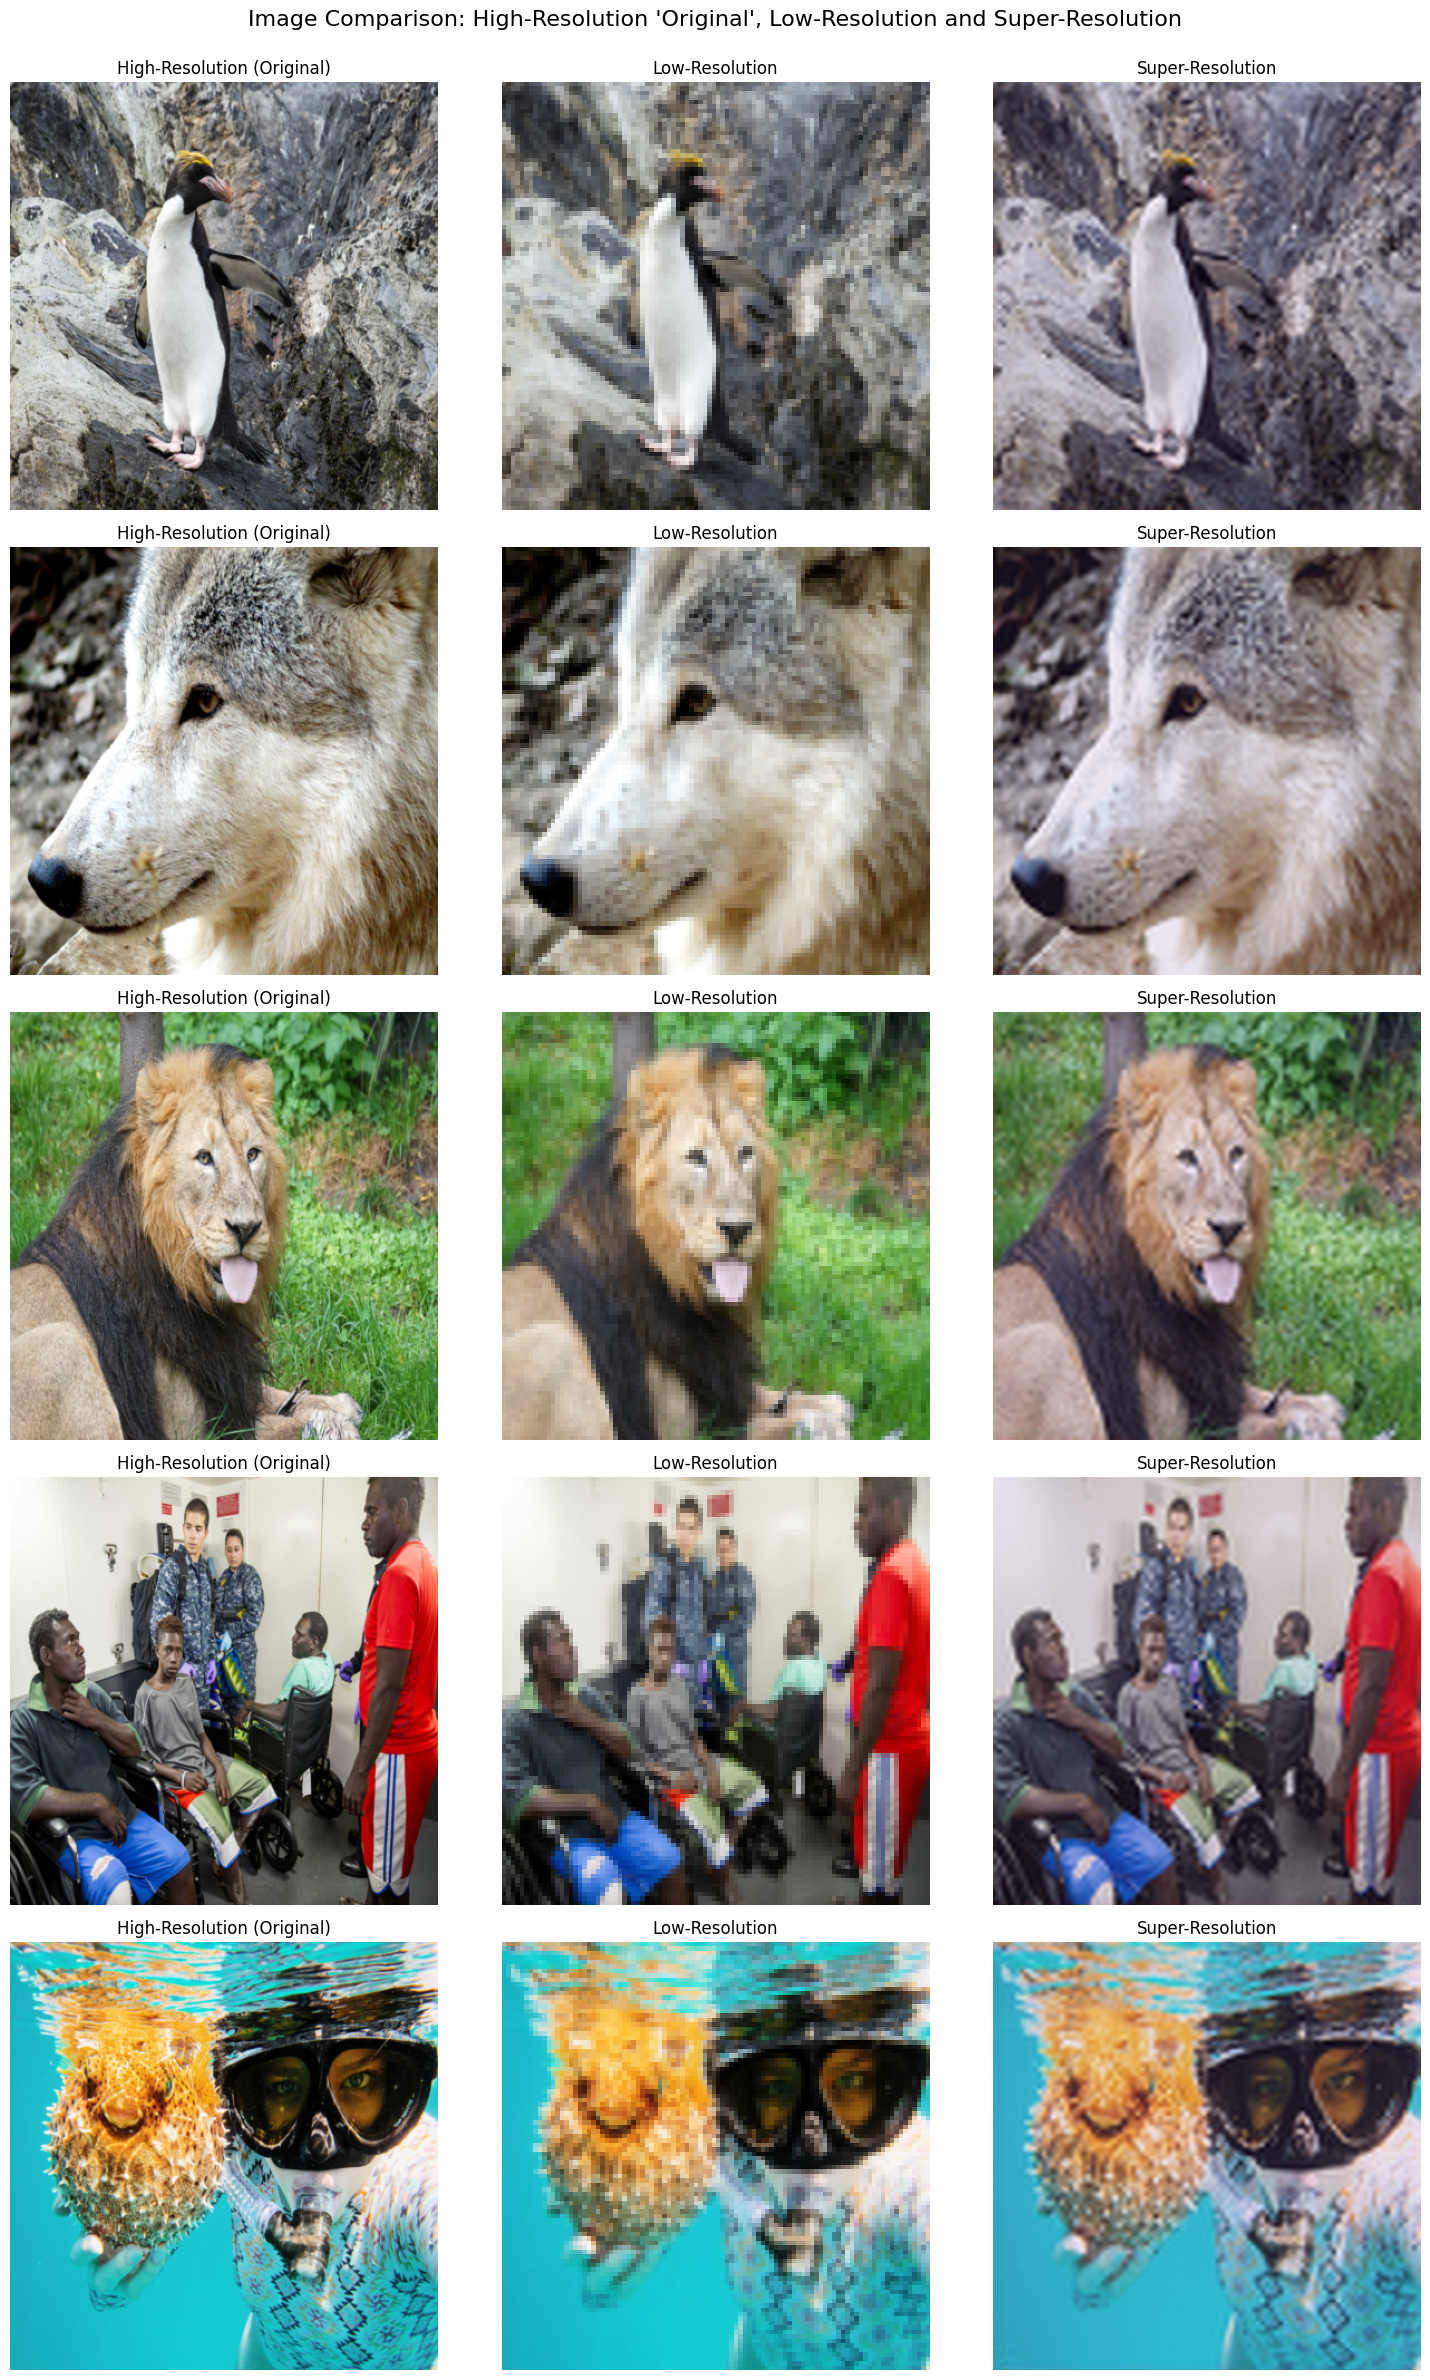

In [40]:
visualize_image_pairs(data_loader=val_loader, model=model, num_images=5)

**Summary Highlights:**

* Improved Visual Quality: SR images significantly enhance detail and reduce pixelation compared to LR inputs.
* Feature Preservation: Key features (e.g., lion's fur, penguin outline) closely match HR originals.
* Color & Structure Restoration: SR images maintain natural color and structure.
* Minor Artifacts: Slight smoothing observed in complex areas.
* Effective Performance: Model performs well, producing high-quality results.

### **Metric-based Evaluation**

In [41]:
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Function to evaluate a batch of images using EDSR
def evaluate_model(data_loader, edsr_model):
    edsr_model.eval()
    psnr_values, ssim_values = [], []

    with torch.no_grad():
        for lr_images, hr_images in data_loader:
            lr_images = lr_images.to("cuda")
            hr_images = hr_images.to("cuda")

            # Perform super-resolution
            sr_images = edsr_model(lr_images)

            # Convert tensors to numpy arrays
            sr_images = sr_images.permute(0, 2, 3, 1).cpu().numpy()
            hr_images = hr_images.permute(0, 2, 3, 1).cpu().numpy()

            for sr, hr in zip(sr_images, hr_images):
                psnr_values.append(psnr(hr, sr, data_range=hr.max() - hr.min()))
                ssim_values.append(ssim(hr, sr, data_range=hr.max() - hr.min(), win_size=3))  # Explicitly set win_size

    # Compute Statistics
    def compute_statistics(values):
        return {
            "Average": np.mean(values),
            "Median": np.median(values),
            "Min": np.min(values),
            "Max": np.max(values),
            "90th Percentile": np.percentile(values, 90),
            "95th Percentile": np.percentile(values, 95),
        }

    psnr_stats = compute_statistics(psnr_values)
    ssim_stats = compute_statistics(ssim_values)

    # Create a DataFrame
    stats_df = pd.DataFrame({
        "Metric": ["PSNR", "SSIM"],
        "Average": [psnr_stats["Average"], ssim_stats["Average"]],
        "Median": [psnr_stats["Median"], ssim_stats["Median"]],
        "Min": [psnr_stats["Min"], ssim_stats["Min"]],
        "Max": [psnr_stats["Max"], ssim_stats["Max"]],
        "90th Percentile": [psnr_stats["90th Percentile"], ssim_stats["90th Percentile"]],
        "95th Percentile": [psnr_stats["95th Percentile"], ssim_stats["95th Percentile"]],
    })

    return stats_df


In [42]:
stats_df = evaluate_model(data_loader=val_loader, edsr_model=model)
stats_df

Metric    Average     Median        Min        Max  90th Percentile  \
0   PSNR  23.977076  23.753310  16.833962  29.865774        26.460155   
1   SSIM   0.715504   0.710091   0.483689   0.955182         0.847460   

   95th Percentile  
0        27.821816  
1         0.915756

**Summary Highlights:**

* PSNR: Average PSNR of 23.98, indicating moderate reconstruction quality; top 5% achieves 27.82, showing potential for improvement.
* SSIM: Average SSIM of 0.715, suggesting acceptable structural similarity; high variability with a max of 0.955.
* Performance Spread: Significant range in both metrics; emphasizes the need for further fine-tuning or addressing harder cases.

## **Save the Model**

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# Save model state_dict to Google Drive
torch.save(model.state_dict(), '/content/drive/My Drive/USD-AAI/edsr_finetuned_x4.pt')
print(f"Model saved with val_loss: {val_loss:.4f} in Google Drive")

Model saved with val_loss: 0.0451 in Google Drive
